In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import SGD
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

+ Download dữ liệu CIFAR10 sau đó chia thành 2 tập dữ liệu train và validation.
+ Chuẩn hóa dữ liệu với mean = 0.5 và std = 0.5

In [3]:
# Define the transformation with normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # chuyển đổi ảnh từ định dạng PIL hoặc NumPy thành một tensor có giá trị nằm trong khoảng [0, 1].
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

# Download the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Check if everything is set up correctly
print(f'Train size: {len(trainset)}, Validation size: {len(valset)}, Test size: {len(testset)}')



Files already downloaded and verified
Files already downloaded and verified
Train size: 40000, Validation size: 10000, Test size: 10000


+ Hiển thị 5 ảnh đầu tiên trong tập dữ liệu testing

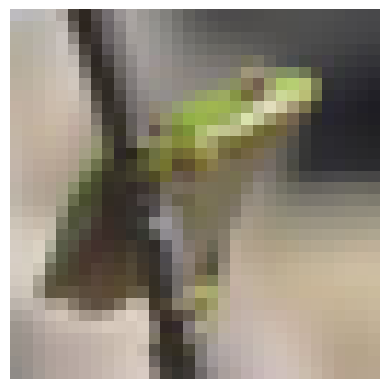

Label: 6


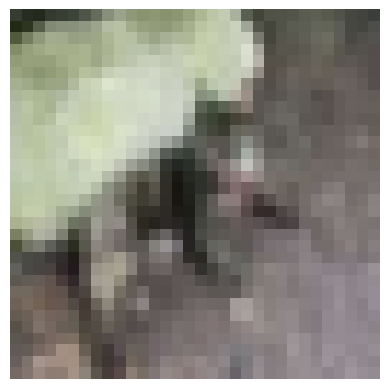

Label: 3


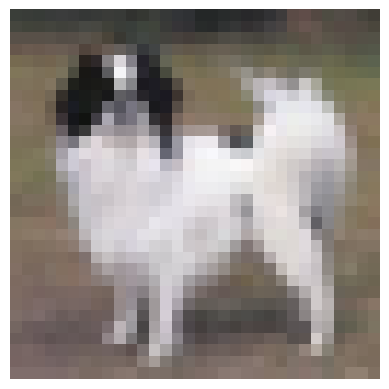

Label: 5


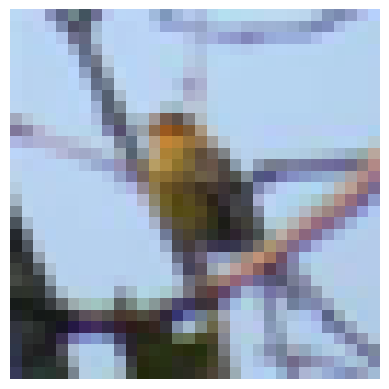

Label: 2


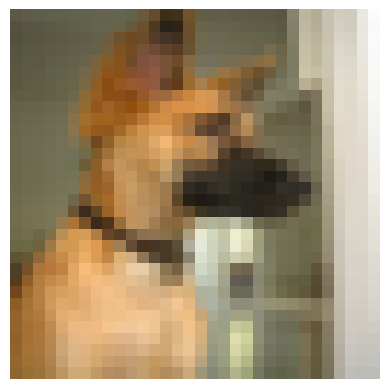

Label: 5


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    # Unnormalize the image (reverse the normalization)
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose dimensions for plotting
    plt.axis('off')  # Turn off axis
    plt.show()

# Load one batch of images
for i, (images, labels) in enumerate(trainloader, 0):
  for j in range(5):
        imshow(images[j])  # Hiển thị ảnh thứ j trong batch
        print('Label:', labels[j].item())  # In ra nhãn cho ảnh thứ j
  break  # Thoát sau batch đầu tiên


+ Xây dựng model MLP cơ bản để train tập dữ liệu CIFAR10

In [7]:
import torch.nn as nn
import torch.nn.functional as F

def getModel(n_features):
    class SimpleCNN(nn.Module):
        def __init__(self):
            super(SimpleCNN, self).__init__()
            # Define the layers
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input: 3 channels, Output: 32 channels
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Input: 32 channels, Output: 64 channels
            self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Fully connected layer
            self.fc2 = nn.Linear(128, n_features)  # Output layer

        def forward(self, x):
            # Define the forward pass
            x = F.relu(self.conv1(x))
            x = F.max_pool2d(x, 2)  # Max pooling
            x = F.relu(self.conv2(x))
            x = F.max_pool2d(x, 2)  # Max pooling
            x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
            x = F.relu(self.fc1(x))
            x = self.fc2(x)  # Output layer
            return x

    model = SimpleCNN()
    return model


+ Khởi tạo hàm loss function và phương thức optimizer

In [17]:
# Set the number of output features for CIFAR-10
n_features = 10  # CIFAR-10 has 10 classes

# Get the model
model = getModel(n_features)

# Set the learning rate
lr = 0.0001

# Define the optimizer (Stochastic Gradient Descent)
optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Define the loss function (Cross Entropy Loss for multi-class classification)
loss_fn = nn.CrossEntropyLoss()

# Print model architecture
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


+ Xây dựng hàm đánh giá model

In [18]:
def evaluate(model, testloader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move to the appropriate device

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            test_loss += loss.item()  # Accumulate loss
            
            _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
            total += labels.size(0)  # Total number of labels
            correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = 100 * correct / total  # Calculate accuracy
    average_loss = test_loss / len(testloader)  # Average loss per batch
    return average_loss, accuracy  # Return average loss and accuracy


+ Bắt đầu training và đánh giá model.

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define optimizer with a lower learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Decay learning rate every 10 epochs

# Training loop
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    # Update learning rate
    scheduler.step()
    
    # Calculate epoch metrics
    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, loss_fn)
    
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Track losses and accuracies
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/30], Loss: 0.8667, Accuracy: 70.06%, Test Loss: 0.9699, Test Accuracy: 66.39%
Epoch [2/30], Loss: 0.8430, Accuracy: 70.87%, Test Loss: 0.9534, Test Accuracy: 67.01%
Epoch [3/30], Loss: 0.8240, Accuracy: 71.66%, Test Loss: 0.9536, Test Accuracy: 66.81%
Epoch [4/30], Loss: 0.8053, Accuracy: 72.41%, Test Loss: 0.9521, Test Accuracy: 67.41%
Epoch [5/30], Loss: 0.7849, Accuracy: 73.08%, Test Loss: 0.9372, Test Accuracy: 67.85%
Epoch [6/30], Loss: 0.7689, Accuracy: 73.52%, Test Loss: 0.9279, Test Accuracy: 68.45%
Epoch [7/30], Loss: 0.7527, Accuracy: 74.02%, Test Loss: 0.9197, Test Accuracy: 68.71%
Epoch [8/30], Loss: 0.7358, Accuracy: 74.82%, Test Loss: 0.9095, Test Accuracy: 68.99%
Epoch [9/30], Loss: 0.7204, Accuracy: 75.17%, Test Loss: 0.9086, Test Accuracy: 69.11%
Epoch [10/30], Loss: 0.7043, Accuracy: 75.75%, Test Loss: 0.9278, Test Accuracy: 68.37%


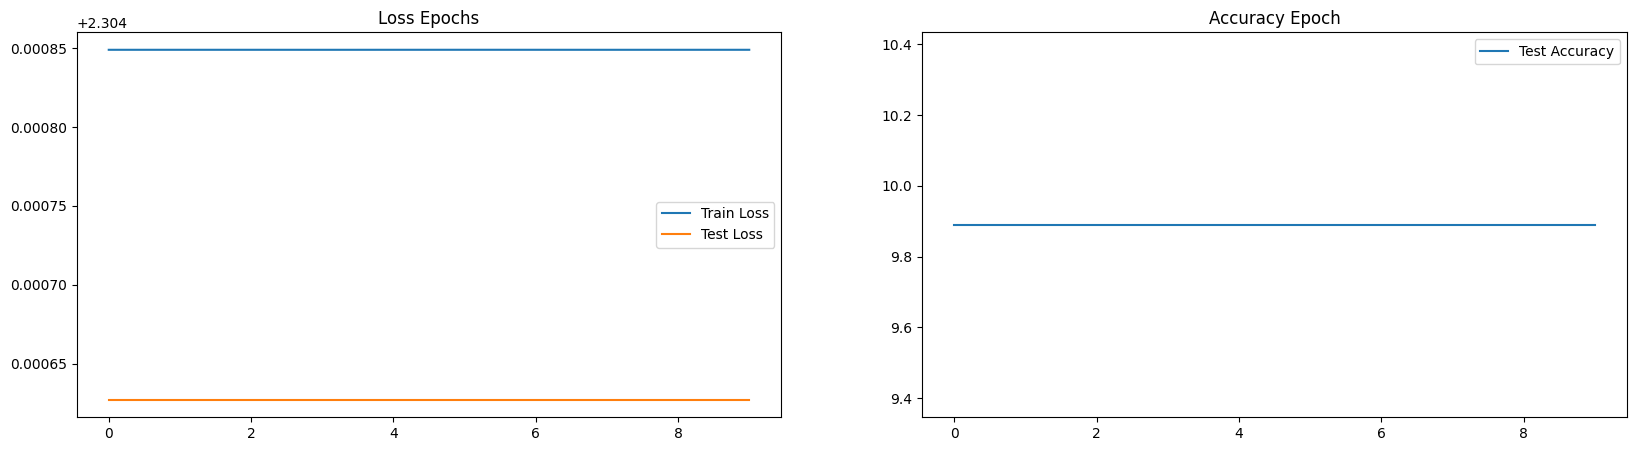

In [11]:
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracies, label = 'Test Accuracy')
plt.legend()

+ Dưới đây là bài tập về code from scratch

In [27]:
import torch

def zScoreScaling(tensor):
    # Ensure the tensor is not empty
    if tensor.numel() == 0:
        raise ValueError("Input tensor is empty.")

    # Calculate mean and standard deviation
    mean = tensor.mean()
    std = tensor.std()

    # Check for zero standard deviation to avoid division by zero
    if std == 0:
        raise ValueError("Standard deviation is zero, scaling cannot be performed.")

    # Perform z-score scaling
    scaled_tensor = (tensor - mean) / std
    return scaled_tensor


In [28]:
import torch

def minMaxScaling(tensor):
    # Ensure the tensor is not empty
    if tensor.numel() == 0:
        raise ValueError("Input tensor is empty.")

    # Calculate the minimum and maximum values
    tensor_min = tensor.min()
    tensor_max = tensor.max()

    # Check if the tensor has constant values
    if tensor_min == tensor_max:
        raise ValueError("The tensor has constant values; scaling cannot be performed.")

    # Perform min-max scaling
    scaled_tensor = (tensor - tensor_min) / (tensor_max - tensor_min)
    return scaled_tensor


In [29]:
import torch
import torch.nn.functional as F

class Linear:
    def __init__(self, in_features, out_features):
        # Initialize weights and biases
        self.weights = torch.randn(out_features, in_features) * 0.01  # Small random weights
        self.biases = torch.zeros(out_features)  # Zero biases

    def forward(self, x):
        # Perform the linear transformation
        return F.linear(x, self.weights, self.biases)

    def parameters(self):
        # Return weights and biases for optimization
        return self.weights, self.biases


In [30]:
tensor = torch.tensor([
    [1.0, 2.0, 3.0], 
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0]
])
zscore = zScoreScaling(tensor)
min_max = minMaxScaling(tensor)
print(zscore)
print(min_max)


tensor([[-1.4606, -1.0954, -0.7303],
        [-0.3651,  0.0000,  0.3651],
        [ 0.7303,  1.0954,  1.4606]])
tensor([[0.0000, 0.1250, 0.2500],
        [0.3750, 0.5000, 0.6250],
        [0.7500, 0.8750, 1.0000]])


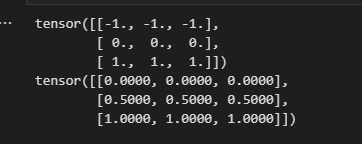

In [31]:
tensor = torch.tensor([1.0, 2.0, 3.0])
linear = Linear(3, 2)
out = linear.forward(tensor)
print(out)
print(f"Weight = {linear.weight}")
print(f"Bias = {linear.bias}")

tensor([-0.0147,  0.0065])


AttributeError: 'Linear' object has no attribute 'weight'